reference:
https://blog.amedama.jp/entry/hyperopt

In [1]:
# basic
import numpy as np
import pandas as pd
import pprint

# plot
#import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# model
from sklearn.svm import SVR

# optimization
from functools import partial
from sklearn.model_selection import KFold, cross_validate
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.metrics import mean_squared_error as MSE, make_scorer

# importance
import eli5
from eli5.sklearn import PermutationImportance

# other
import pickle
import time
import datetime

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\app-data\miniconda-dir\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

train_test = pd.concat([train, test], ignore_index=True, sort=False)

# Preprocessing

## car name, car brand

In [3]:
train_test['car name'] = train_test['car name'].str.replace('vw', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('vokswagen', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('toyouta', 'toyota')
train_test['car name'] = train_test['car name'].str.replace('chevy', 'chevrolet')
train_test['car name'] = train_test['car name'].str.replace('datsun 200-sx', 'datsun 200sx')

train_test['car name'] = train_test['car name'].str.replace('datsun 210 mpg', 'datsun 210')
train_test['car name'] = train_test['car name'].str.replace('ford gran torino (sw)', 'ford gran torino')

In [4]:
train_test['car_brand'] = train_test['car name'].apply(lambda x: x.strip().split(' ')[0])

## horse power

In [5]:
# convert to float
train_test['horsepower'].replace('?', np.nan, inplace=True)
train_test['horsepower'] = train_test['horsepower'].astype(float)

# car name毎のhorse powerの平均値を計算(nanは計算外)
name_hp_mean = train_test.groupby('car name').horsepower.mean()
df_hp_isnull = train_test[train_test['horsepower'].isnull()]

# nan位置のtrainデータのhorse powerを置換する
for i in df_hp_isnull.index:
    train_test.loc[i, 'horsepower'] = name_hp_mean[df_hp_isnull.loc[i, 'car name']]
    
del df_hp_isnull, name_hp_mean

# Standard Scaler

In [6]:
cols = ['displacement', 'horsepower', 'acceleration']

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

train_test[cols] = scaler.fit_transform(train_test[cols])

display(train_test)

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,car_brand
0,0,23.059782,6,-0.483685,0.143900,2815,1.195071,80,1,dodge aspen,dodge
1,3,17.674521,8,1.521800,1.333045,4456,-0.797646,72,1,dodge rampage,dodge
2,4,17.136353,8,1.063404,1.035759,2774,-0.933663,79,1,mercury cougar brougham,mercury
3,7,22.664666,6,1.999297,-0.599315,2190,-0.046689,71,1,pontiac j2000 se hatchback,pontiac
4,9,17.872018,8,2.276245,3.414047,2245,-2.535961,70,1,ford galaxie 500,ford
...,...,...,...,...,...,...,...,...,...,...,...
995,992,NaN,4,0.328059,-0.004743,3870,0.033651,76,1,chevrolet nova,chevrolet
996,993,NaN,4,-0.483685,0.203358,2720,-0.751965,82,1,buick century limited,buick
997,996,NaN,8,1.216202,0.143900,2774,-0.905656,75,1,ford ltd,ford
998,998,NaN,4,-0.961181,-0.896601,2807,1.112525,77,1,dodge monaco brougham,dodge


# Drop unimportant features

In [8]:
train_test.drop(['car name', 'car_brand'], axis=1, inplace=True)
display(train_test)

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,0,23.059782,6,-0.483685,0.143900,2815,1.195071,80,1
1,3,17.674521,8,1.521800,1.333045,4456,-0.797646,72,1
2,4,17.136353,8,1.063404,1.035759,2774,-0.933663,79,1
3,7,22.664666,6,1.999297,-0.599315,2190,-0.046689,71,1
4,9,17.872018,8,2.276245,3.414047,2245,-2.535961,70,1
...,...,...,...,...,...,...,...,...,...
995,992,NaN,4,0.328059,-0.004743,3870,0.033651,76,1
996,993,NaN,4,-0.483685,0.203358,2720,-0.751965,82,1
997,996,NaN,8,1.216202,0.143900,2774,-0.905656,75,1
998,998,NaN,4,-0.961181,-0.896601,2807,1.112525,77,1


# Encoding

In [9]:
cat_cols = ['cylinders', 'model year', 'origin']#, 'car name', 'car_brand']
train_test = pd.get_dummies(
    train_test,
    columns=cat_cols, 
    sparse=False
)

display(train_test)

,id,mpg,displacement,horsepower,weight,acceleration,cylinders_4,cylinders_6,cylinders_8,model year_70,...,model year_76,model year_77,model year_78,model year_79,model year_80,model year_81,model year_82,origin_1,origin_2,origin_3
0,0,23.059782,-0.483685,0.143900,2815,1.195071,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,3,17.674521,1.521800,1.333045,4456,-0.797646,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,4,17.136353,1.063404,1.035759,2774,-0.933663,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,7,22.664666,1.999297,-0.599315,2190,-0.046689,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,9,17.872018,2.276245,3.414047,2245,-2.535961,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,992,NaN,0.328059,-0.004743,3870,0.033651,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
996,993,NaN,-0.483685,0.203358,2720,-0.751965,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
997,996,NaN,1.216202,0.143900,2774,-0.905656,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
998,998,NaN,-0.961181,-0.896601,2807,1.112525,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


# Create Model

In [10]:
test_treated = train_test[train_test['mpg'].isnull()].copy()
train_treated = train_test.dropna(subset=['mpg'], axis=0).copy()

train_X = train_treated.drop(['id', 'mpg'], axis=1)
train_y = train_treated['mpg']

In [11]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

def objective(X, y, args):
    model = SVR(**args)
    
    kf = KFold(n_splits=4, shuffle=True, random_state=1)
    
    score_func = {
        'score':make_scorer(RMSE)
    }
    
    cv_result = cross_validate(model, X=X, y=y, cv=kf, return_estimator=True, scoring=score_func)
    #models.append(cv_result['estimator'])
    
    return {
        'loss':cv_result['test_score'].mean(),
        'status':STATUS_OK,
        'params':args
    }

In [27]:
#models = []

f = partial(objective, train_X, train_y)

param_space = {
    'kernel': 'rbf',
    'C': hp.loguniform(
        label='C', low=np.log(10), high=np.log(20)
    ),
    'epsilon':hp.loguniform(
        label='epsilon', low=np.log(1e-8), high=np.log(2.5)
    ),
    'gamma': hp.loguniform(
        label='gamma', low=np.log(1e-8), high=np.log(2.5)
    )
}

trials=Trials()

best = fmin(
    fn=f,
    space=param_space, 
    algo=tpe.suggest,
    max_evals=500,
    trials=trials
)

100%|███████████████████████████████████████████████| 500/500 [00:35<00:00, 14.07trial/s, best loss: 4.085841294985385]


In [28]:
# trialsからスコアとパラメータを取り出し
result = [(i['loss'], i['params']) for i in sorted(trials.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses = [i[0] for i in result]
opt_params = [i[1] for i in result]
# スコアとパラメータをDataFrame化
opt_params_df = pd.concat([pd.Series(losses, name='loss'), pd.DataFrame(opt_params)], axis=1)
display(opt_params_df)

,loss,C,epsilon,gamma,kernel
0,4.085841,17.717206,8.231813e-01,7.257450e-02,rbf
1,4.088429,17.562114,8.073034e-01,6.183506e-02,rbf
2,4.091735,18.560458,4.981184e-01,6.184669e-02,rbf
3,4.100112,18.665792,1.817303e-01,8.298459e-02,rbf
4,4.100735,19.352781,3.487578e-01,5.717225e-02,rbf
...,...,...,...,...,...
495,7.358909,18.752389,7.498839e-07,2.661600e-08,rbf
496,7.361884,14.415098,8.780314e-02,3.318768e-08,rbf
497,7.363342,16.667265,1.073870e-05,2.384843e-08,rbf
498,7.371340,19.974379,1.997360e-07,1.138965e-08,rbf


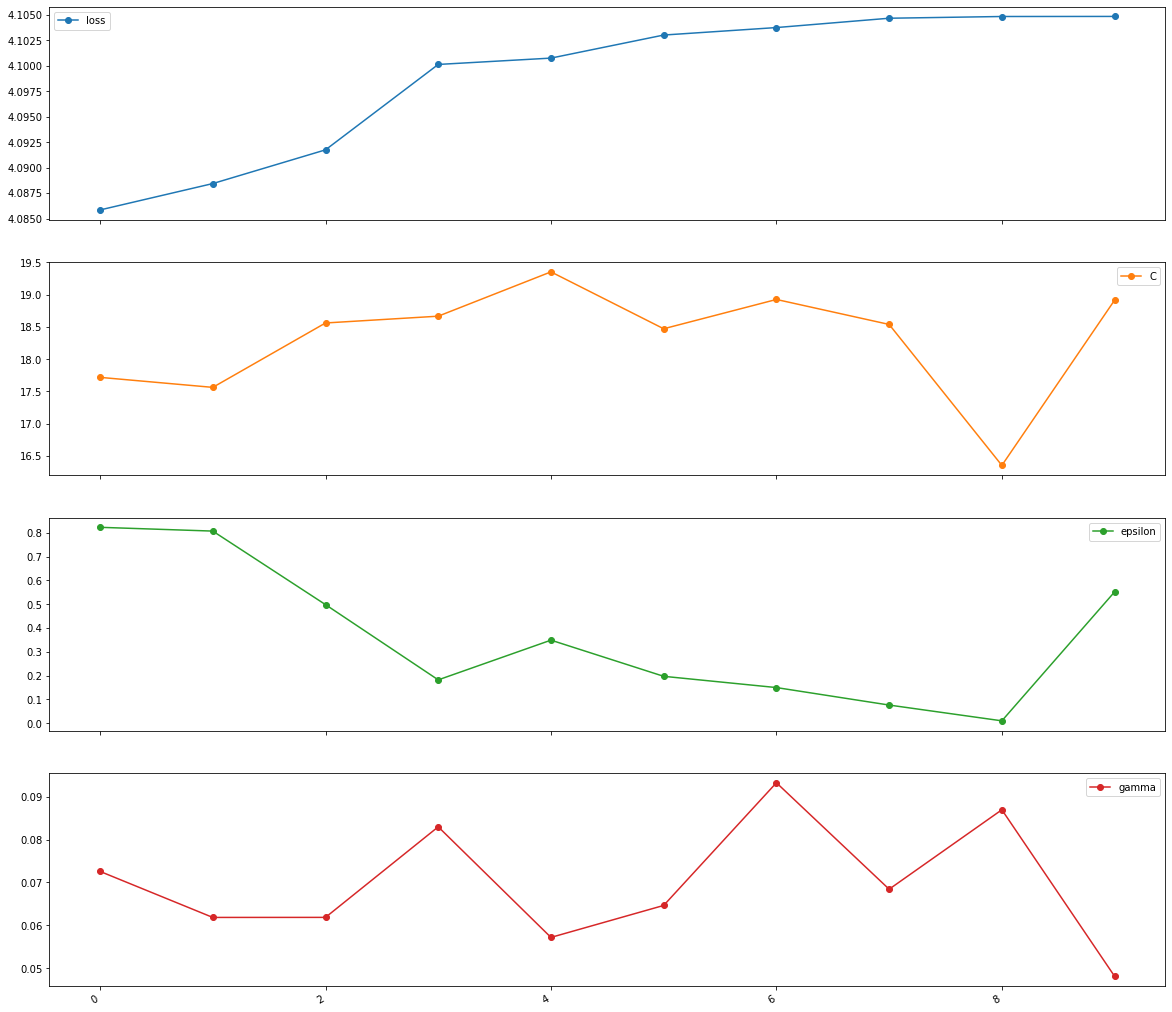

In [29]:
opt_params_df.iloc[:10, :4].plot.line(figsize=(20, 20), layout=(4, 1), marker='o', subplots=True)
plt.show()

In [30]:
# ベストスコアとそのときのパラメータを記録
best_loss = losses[0]
best_params = opt_params[0]

# Create Submission

In [31]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
submission = pd.DataFrame({'id':sample_sub.id})
importance_list = []

best_model = SVR(**best_params)
best_model.fit(train_X, train_y)
submission = pd.concat(
    [submission, pd.Series(best_model.predict(test_treated.drop(['id', 'mpg'], axis=1)), name='pred')],
    axis=1
)

display(submission)

,id,pred
0,1,35.726022
1,2,25.864499
2,5,27.449544
3,6,27.458509
4,8,23.971703
...,...,...
495,992,25.172339
496,993,23.207702
497,996,18.062413
498,998,27.449550


### Save files

In [32]:
# features
train_treated.to_pickle('../features/feature_train_' + dt + '_car_name_drop.pkl')
test_treated.to_pickle('../features/feature_test_' + dt + '_car_name_drop.pkl')

# submission
submission[['id', 'pred']].to_csv('../data/output/sub_' + dt + '_svr.csv', header=False, index=False)
# model
pickle.dump(best_model, open('../models/model_' + dt + '_svr.pickle', 'wb'))
# best parameter
pickle.dump(best_params, open('../logs/params_' + dt + '.pickle', 'wb'))
# best train score
pickle.dump(best_loss, open('../logs/logs_test_score' + dt + '.pickle', 'wb'))

# Feature Importance

In [33]:
from collections import defaultdict
from sklearn.model_selection import KFold

In [34]:
def permuted(df):
    for col in df.columns:
        permuted_df = df.copy()
        permuted_df[col] = np.random.permutation(permuted_df[col])
        yield col, permuted_df

In [35]:
def pimp(clf, x, y, kf=None, eval_func=RMSE):
    base_scores=[]
    perm_scores = defaultdict(list)
    
    if kf is None:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for tr_idx, va_idx in kf.split(x, y):
        tr_x, tr_y = x.iloc[tr_idx], y.iloc[tr_idx]
        va_x, va_y = x.iloc[va_idx], y.iloc[va_idx]
        
        clf.fit(tr_x, tr_y)
        
        y_pred_base = clf.predict(va_x)
        base_score = eval_func(va_y, y_pred_base)
        base_scores.append(base_score)
        
        perm_va_x_gen = permuted(va_x)
        for col, perm_va_x in perm_va_x_gen:
            y_pred_perm = clf.predict(perm_va_x)
            perm_score = eval_func(va_y, y_pred_perm)
            perm_scores[col].append(perm_score)
            
    np_base_score = np.array(base_score)
    dict_perm_score = {name:np.array(scores) for name, scores in perm_scores.items()}
    return np_base_score, dict_perm_score

In [36]:
def score_diff_stat(base, perm):
    mean_base_score = base.mean()
    for col, scores in perm.items():
        score_diff = scores - mean_base_score
        yield col, score_diff.mean(), score_diff.std()

In [37]:
# Permutation Importanceを計算
base_score, perm_scores = pimp(best_model, train_X, train_y)
pprint.pprint(base_score)
pprint.pprint(perm_scores)

array(4.51466047)
{'acceleration': array([4.43255113, 3.72317595, 3.95512735, 4.03825347, 4.71810136]),
 'cylinders_4': array([3.89891714, 3.49994294, 3.71597086, 3.57888533, 4.58954413]),
 'cylinders_6': array([3.82096023, 3.42474993, 3.74641588, 3.54971621, 4.54178131]),
 'cylinders_8': array([3.88703876, 3.40217274, 3.65815196, 3.55852564, 4.51478738]),
 'displacement': array([4.25630769, 3.6661876 , 4.07877005, 4.08077338, 4.85643227]),
 'horsepower': array([4.07247932, 3.46972891, 3.7761595 , 3.70278833, 4.78373063]),
 'model year_70': array([3.86635192, 3.43370784, 3.68305283, 3.56165614, 4.51458571]),
 'model year_71': array([3.85863371, 3.4163974 , 3.81051644, 3.56023462, 4.58828863]),
 'model year_72': array([3.84949177, 3.42648046, 3.67957691, 3.54637558, 4.51628397]),
 'model year_73': array([3.85911322, 3.42455293, 3.67493415, 3.52890382, 4.51880914]),
 'model year_74': array([3.86844389, 3.45442115, 3.67562964, 3.55631508, 4.5205426 ]),
 'model year_75': array([3.87177035,

In [38]:
# カラム名、base scoreとの差、95%信頼区間を取り出す
diff_stat = list(score_diff_stat(base_score, perm_scores))
sorted_diff_stat = sorted(diff_stat, key=lambda x:x[1])
col = [name for name, _, _ in sorted_diff_stat]
diff_means = [diff_mean for _, diff_mean, _ in sorted_diff_stat]
diff_std_95 = [diff_std * 1.96 for _, _, diff_std in sorted_diff_stat]

In [39]:
sorted_diff_stat

[('model year_73', -0.7133978189599646, 0.38736754850474703),
 ('model year_82', -0.7129783968894771, 0.4043699260827381),
 ('model year_79', -0.71137163157895, 0.3832324840832891),
 ('model year_72', -0.7110187324825537, 0.3830900051280772),
 ('cylinders_8', -0.7105251725589548, 0.3886151061832758),
 ('model year_77', -0.7102682231697302, 0.3962017083787289),
 ('model year_80', -0.7074278425926164, 0.3759450134692924),
 ('model year_75', -0.7072215210304147, 0.38075286558867955),
 ('model year_70', -0.7027895832713158, 0.37920577674188294),
 ('model year_81', -0.7005831121041739, 0.3698071994525301),
 ('model year_74', -0.6995899996344627, 0.3786834230063135),
 ('model year_76', -0.6992017254325441, 0.37839866884513357),
 ('cylinders_6', -0.6979357560722483, 0.38874313144675776),
 ('model year_78', -0.6907611563396038, 0.37893990769456404),
 ('origin_2', -0.6841438147698953, 0.3987644368242153),
 ('model year_71', -0.6678463107471659, 0.404630212636181),
 ('origin_3', -0.6633923356476